In [1]:
import os
import logging

import contextlib
from wordcloud import WordCloud

from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.explainable.handlers.components import ExtractSupports


from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

import seaborn as sns
import numpy as np
from typing import List, Tuple, Dict, Any, Union
import matplotlib.pyplot as plt
import dill
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
from chirho.observational.handlers.condition import condition
from chirho.interventional.handlers import do
from typing import Dict, Optional

import torch

import pyro
import pyro.distributions as dist

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 2000

from cities.utils.data_grabber import find_repo_root
root = find_repo_root()

full zoning dataset within the period 410
after dropping university 326
154


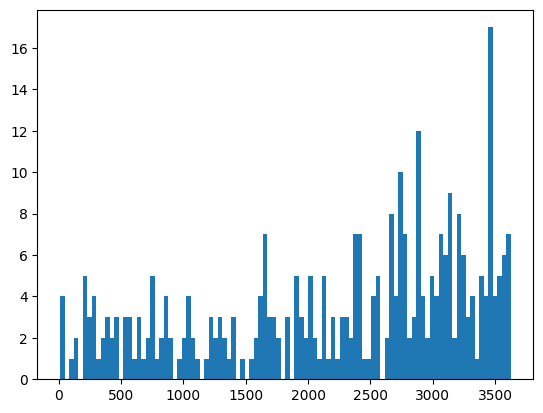

In [2]:
zoning_raw = pd.read_csv(os.path.join(root,"data/minneapolis/sourced/per_unit_parking.csv"))


#drop project name, address
zoning = zoning_raw.drop(columns=["project_name","address"])

# check nas
nas = zoning.isna().sum()
assert nas.sum() == 0


zoning['date'] = pd.to_datetime(zoning['date'])
start_date = pd.to_datetime('2011-01-01')

zoning['year'] = zoning['date'].dt.year
zoning['year_id'] = pd.factorize(zoning['year'])[0]

#drop year > 2020
zoning = zoning[zoning['year'] <= 2020]

#drop university of minnesota
print("full zoning dataset within the period", len(zoning))
zoning = zoning[zoning['university_yn'] == False]
print("after dropping university", len(zoning)) 


zoning['month'] = zoning['date'].dt.month
zoning['day']  = (zoning['date'] - start_date).dt.days


plt.hist(zoning['day'], bins=100) #note not only within-permit limits but also numbers of permissions is important
# and that the number of permissions is not stationary

print(len(zoning['day'].unique())) # note it seems like there have been 153 days with updates,
                                   # reason to believe that the data is not really daily


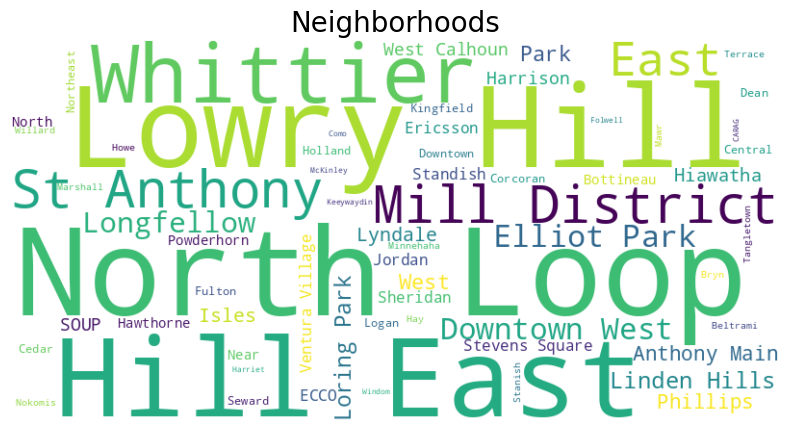

0.7116564417177914


In [3]:
# wordcloud to quickly check for typos
text = ' '.join(zoning['neighborhood'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neighborhoods', fontsize=20)
plt.show()

# note: neighborhoods might be important, perhaps partially because causally related to parcel size?

# parking reform was passed: July 10, 2015
reform = pd.to_datetime('2015-07-10')
reform_day = (reform - start_date).days

zoning['past_reform'] = zoning['date'] > reform

print(
zoning['past_reform'].mean()
#note 71 % permits are after the reform
)



limit
eliminated    190
full           82
reduced        54
Name: count, dtype: int64
neigh [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
wards [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


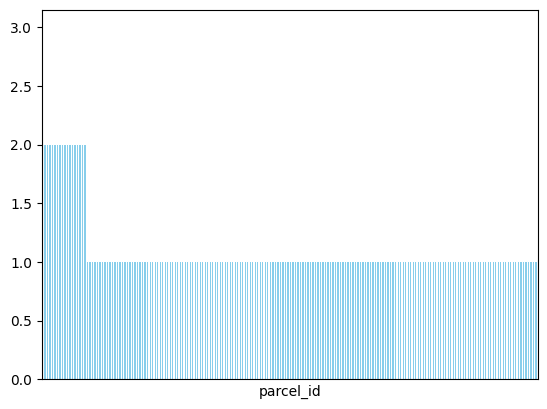

In [4]:

criteria = ['past_reform', 'res_parking_elim_2015_yn', 'res_parking_reduced_2015_yn']

replacement_dict = {
    'FalseFalseFalse': 'full',
    'FalseTrueFalse': 'full',
    'FalseFalseTrue': 'full',
    'FalseTrueTrue': 'full',
    'TrueFalseFalse': 'full',
    'TrueTrueFalse': 'eliminated',
    'TrueFalseTrue': 'reduced',
    'TrueTrueTrue': 'eliminated' 
}

zoning['limit'] = zoning[criteria].astype(str).agg(''.join, axis=1).replace(replacement_dict)

zoning.loc[zoning['downtown_yn'], 'limit'] = 'eliminated'

limit_ordering = ['eliminated', 'reduced', 'full']

zoning['limit'] = pd.Categorical(zoning['limit'], categories=limit_ordering, ordered=True)

zoning['limit_id'] = zoning['limit'].cat.codes

#sanity check
print(zoning['limit'].value_counts())



columns_to_factorize = ['year', 'month', 'day', 'neighborhood', 'ward']

for column in columns_to_factorize:
    zoning[column + '_id'] = pd.factorize(zoning[column])[0]



print("neigh", zoning['neighborhood_id'].unique() )
print("wards", zoning['ward_id'].unique() )
# 76 neighborhoods, 13 wards


# note one or two permits per parcel, no strong reason to use parcels as units of analysis
zoning['parcel_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


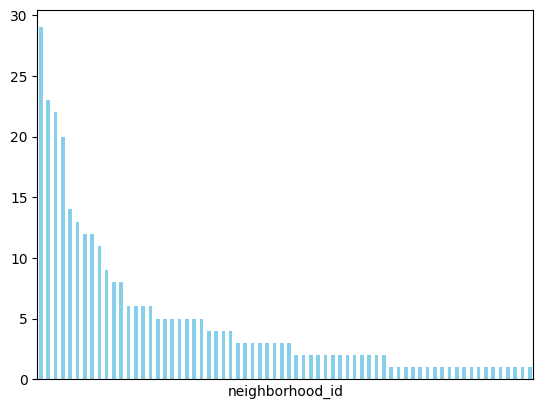

,parcel_id,date,neighborhood,ward,downtown_yn,housing_units,car_parking,bike_parking,parcel_area,university_yn,...,past_reform,limit,limit_id,month_id,day_id,neighborhood_id,ward_id,housing_units_std,car_parking_std,parcel_area_std
0,2602924310063,2011-01-10,Elliot Park,6,True,7,0,0,7245.893155,False,...,False,eliminated,0,0,0,0,0,-0.893078,-0.821149,-0.621041
1,102824440106,2011-01-10,Stanish Ericsson,12,False,64,74,80,38210.631831,False,...,False,full,2,0,0,1,1,-0.338982,-0.111109,0.011602
2,2702924430325,2011-01-10,Stevens Square,6,False,123,104,62,73747.490123,False,...,False,full,2,0,0,2,0,0.234556,0.176745,0.737659
3,3302924440363,2011-02-07,Lowry Hill East,10,False,198,240,108,70847.105465,False,...,False,full,2,1,1,3,2,0.963630,1.481683,0.678401
5,1702823340059,2011-04-11,Nokomis East,12,False,42,42,21,52590.828770,False,...,False,full,2,2,2,4,1,-0.552844,-0.418154,0.305405


In [5]:

# we might have a shot with neighborhoods as units of analysis
zoning['neighborhood_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


columns_to_standardize = ['housing_units', 'car_parking', 'parcel_area']

for column in columns_to_standardize:
    zoning[column + '_std'] = (zoning[column] - zoning[column].mean()) / zoning[column].std()

display(zoning.head())


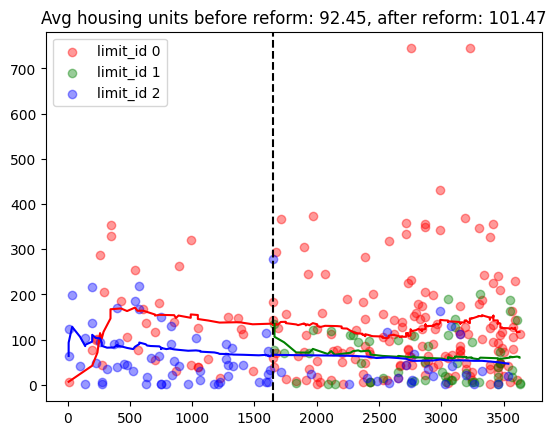

In [6]:
window_size = 60

rolling_avgs = {}
for limit_id, group in zoning.groupby('limit_id'):
    rolling_avgs[limit_id] = group['housing_units'].rolling(window_size, min_periods=1).mean()

rolling_total = zoning['housing_units'].rolling(window_size, min_periods=1).sum()
rolling_avg = zoning['housing_units'].rolling(window_size, min_periods=1).mean()


for limit_id, color in enumerate(['red', 'green', 'blue']):
    plt.scatter(x=zoning[zoning['limit_id'] == limit_id]['day'], y=zoning[zoning['limit_id'] == limit_id]['housing_units'],
                alpha=0.4, c=color, label=f'limit_id {limit_id}')
    plt.plot(zoning[zoning['limit_id'] == limit_id]['day'], rolling_avgs[limit_id], c=color)

plt.axvline(reform_day, color='black', linestyle='--')

# possibly plot running total sum, seems to be an increase after the reform
#plt.plot(zoning['day'], rolling_total, c='black', label='total', linestyle='--')

#possibly plot running average
# average permit size does not increase too much
#plt.plot(zoning['day'], rolling_avg, c='black', label='total', linestyle='--')

# average before reform
avg_before = zoning[zoning['day'] < reform_day]['housing_units'].mean()
avg_after = zoning[zoning['day'] >= reform_day]['housing_units'].mean()

plt.title(f'Avg housing units before reform: {avg_before:.2f}, after reform: {avg_after:.2f}')
plt.legend()
plt.show()

# note the red line doesn't have to upwards to show that the lower limits have effect

# also: think hard what it is that we care about trying to predict, there are many ways to conceptualize the problem

# for now, the question we're trying to aswer is: what is the effect of limit class on the number of housing units

#note initial and final periods might have laged/incomplete data, 

In [7]:
# tensor prep

housing_units = torch.tensor(zoning['housing_units_std'].values, dtype=torch.float)

parcel_area = torch.tensor(zoning['parcel_area_std'].values, dtype=torch.float)

limit_id = torch.tensor(zoning['limit_id'].values, dtype=torch.long)
neighborhood_id = torch.tensor(zoning['neighborhood_id'].values, dtype=torch.long)

outcome = housing_units

categorical = {'limit_id': limit_id,
               'neighborhood_id': neighborhood_id}

continuous = {"parcel_area": parcel_area} #, "parcel_area2": parcel_area} #with an eye on generality


[iteration 0001] loss: 1129.9303
[iteration 0050] loss: 623.1448
[iteration 0100] loss: 479.4424
[iteration 0150] loss: 450.1743
[iteration 0200] loss: 441.7196
[iteration 0250] loss: 441.0372
[iteration 0300] loss: 441.3616
[iteration 0350] loss: 442.9644
[iteration 0400] loss: 442.9122
[iteration 0450] loss: 441.6554
[iteration 0500] loss: 447.7127
[iteration 0550] loss: 433.8929
[iteration 0600] loss: 440.8688
[iteration 0650] loss: 434.6439
[iteration 0700] loss: 438.9165
[iteration 0750] loss: 437.4722
[iteration 0800] loss: 447.2344
[iteration 0850] loss: 438.3062
[iteration 0900] loss: 444.7804
[iteration 0950] loss: 437.8235
[iteration 1000] loss: 435.6432
[iteration 1050] loss: 435.1264
[iteration 1100] loss: 431.2165
[iteration 1150] loss: 436.1516
[iteration 1200] loss: 432.1813
[iteration 1250] loss: 433.9874
[iteration 1300] loss: 433.6275
[iteration 1350] loss: 431.1349
[iteration 1400] loss: 436.2707
[iteration 1450] loss: 427.7212
[iteration 1500] loss: 435.8260
[iterat

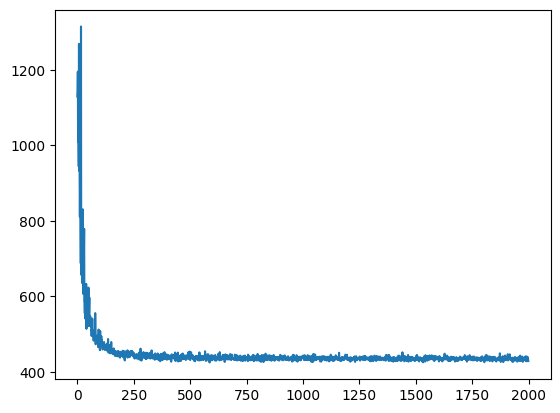

In [8]:
linear_model = SimpleLinear(categorical, continuous, outcome)
model_kwargs = {"categorical": categorical, "continuous": continuous, "outcome": outcome}

#linear_model = condition(linear_model, data = {"outcome_observed": outcome})


guide = run_svi_inference(
    linear_model, n_steps=n_steps, lr=0.01, verbose=True, **model_kwargs
)

In [9]:
predictive = Predictive(linear_model, guide=guide, num_samples=num_samples, parallel=True)

samples = predictive(categorical, continuous, outcome)

1000


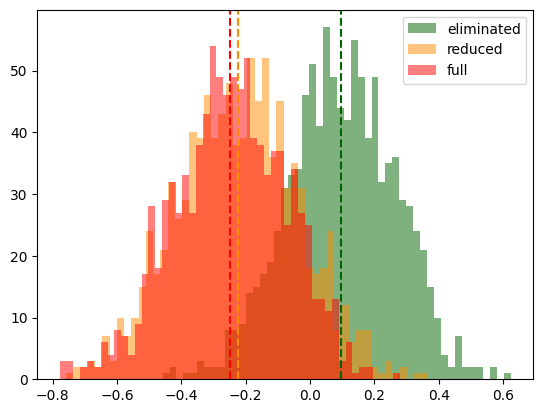

In [10]:
samples.keys()

limit_samples = samples['weights_categorical_limit_id'].squeeze()

limit_samples.shape

eliminated = limit_samples[:, 0]
reduced = limit_samples[:, 1]
full = limit_samples[:, 2]

print(len(eliminated))

plt.hist(eliminated, bins=50, alpha=0.5, color = "darkgreen", label='eliminated')
plt.hist(reduced, bins=50, alpha=0.5, color = "darkorange", label='reduced')
plt.hist(full, bins=50, alpha=0.5, color = "red", label='full')
# add colored lines for means
plt.axvline(eliminated.mean(), color='darkgreen', linestyle='--')
plt.axvline(reduced.mean(), color='darkorange', linestyle='--')
plt.axvline(full.mean(), color='red', linestyle='--')
plt.legend()
plt.show()


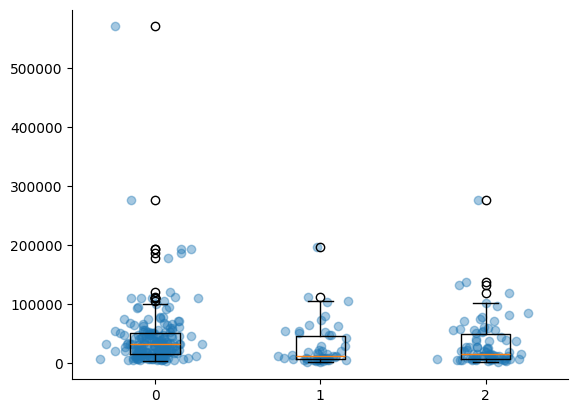

In [11]:
# plot parcel area vs. limit
jitter = np.random.normal(0, 0.1, size=len(zoning))
plt.scatter( y = zoning['parcel_area'] , x = zoning['limit_id'] + jitter, alpha=0.4)
plt.boxplot([zoning[zoning['limit_id'] == 0]['parcel_area'],
             zoning[zoning['limit_id'] == 1]['parcel_area'],
             zoning[zoning['limit_id'] == 2]['parcel_area']],
            positions=[0, 1, 2])
sns.despine()
plt.show()



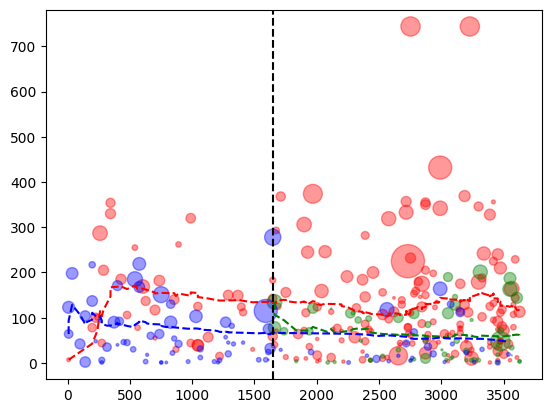

In [12]:
for limit_id, color in enumerate(['red', 'green', 'blue']):
    plt.scatter(x=zoning[zoning['limit_id'] == limit_id]['day'], y=zoning[zoning['limit_id'] == limit_id]['housing_units'],
                alpha=0.4, c=color, label=f'limit_id {limit_id}',
                s=zoning[zoning['limit_id'] == limit_id]['parcel_area'] * 1e-3)
    plt.plot(zoning[zoning['limit_id'] == limit_id]['day'], rolling_avgs[limit_id], c=color, linestyle='--')
plt.axvline(reform_day, color='black', linestyle='--')
plt.show()

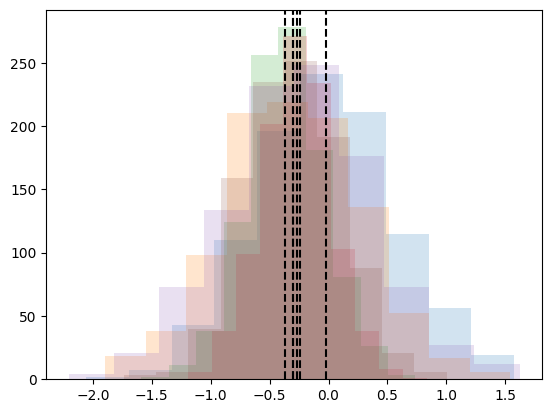

In [13]:
neighborhood_id_samples = samples['weights_categorical_neighborhood_id'].squeeze()
neighborhood_id_samples.shape

for i in [1,4,5, 23, 52, 65]:
    plt.hist(neighborhood_id_samples[:, i], alpha=0.2)
    plt.axvline(neighborhood_id_samples[:, i].mean(), color='black', linestyle='--')

plt.show()


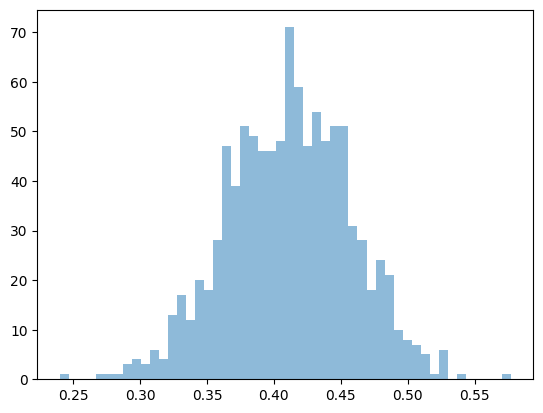

In [14]:
weight_parcel_area = samples['weight_continuous'].squeeze()

plt.hist(weight_parcel_area, bins=50, alpha=0.5)
plt.show()

[iteration 0001] loss: 514.5845
[iteration 0050] loss: 460.0366
[iteration 0100] loss: 459.5029
[iteration 0150] loss: 453.1967
[iteration 0200] loss: 453.9915
[iteration 0250] loss: 453.8796
[iteration 0300] loss: 455.1964
[iteration 0350] loss: 455.2627
[iteration 0400] loss: 453.6870
[iteration 0450] loss: 453.7612
[iteration 0500] loss: 453.7216
[iteration 0550] loss: 454.1465
[iteration 0600] loss: 454.1294
[iteration 0650] loss: 454.2722
[iteration 0700] loss: 453.9478
[iteration 0750] loss: 454.4257
[iteration 0800] loss: 453.6808
[iteration 0850] loss: 454.0607
[iteration 0900] loss: 454.2776
[iteration 0950] loss: 454.5062
[iteration 1000] loss: 453.8259
[iteration 1050] loss: 453.6100
[iteration 1100] loss: 454.7991
[iteration 1150] loss: 453.1146
[iteration 1200] loss: 453.8954
[iteration 1250] loss: 454.2771
[iteration 1300] loss: 454.7909
[iteration 1350] loss: 453.4764
[iteration 1400] loss: 454.3234
[iteration 1450] loss: 454.2401
[iteration 1500] loss: 454.5397
[iterati

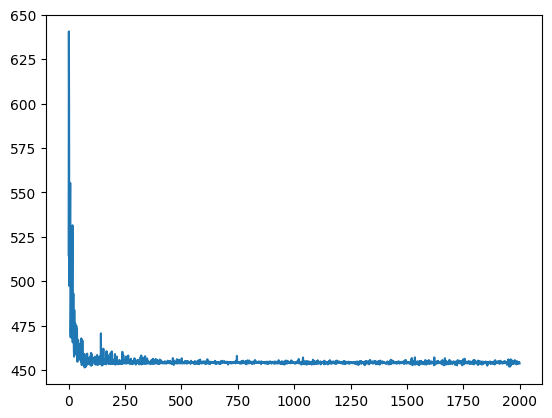

In [15]:
#clear pyro param
pyro.clear_param_store()

linear_model_limit = SimpleLinear(categorical = {'limit_id': categorical['limit_id']},
                                 continuous = {}, outcome=outcome)

#linear_model_limit = condition(linear_model_limit, data = {"outcome_observed": outcome})

model_kwargs_limit = {"categorical": {'limit_id': categorical['limit_id']}, "continuous": {},
                      "outcome": outcome}

guide_limit = run_svi_inference(
    linear_model_limit, n_steps=n_steps, lr=0.01, verbose=True, **model_kwargs_limit
)

1000


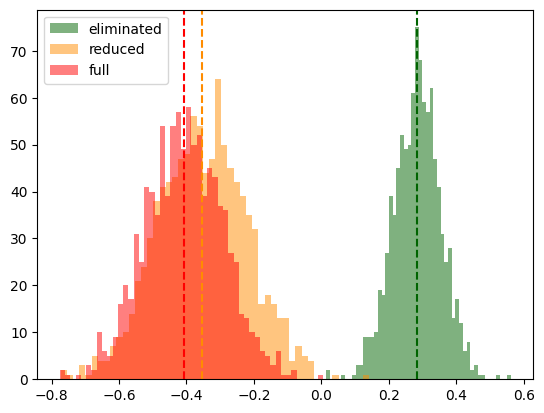

In [16]:
predictive_limit = Predictive(linear_model_limit, guide=guide_limit, num_samples=num_samples)

samples_limit = predictive_limit({'limit_id': categorical['limit_id']}, continuous = {})

samples_limit.keys()


limit_samples = samples_limit['weights_categorical_limit_id'].squeeze()

limit_samples.shape

eliminated = limit_samples[:, 0]
reduced = limit_samples[:, 1]
full = limit_samples[:, 2]

print(len(eliminated))

plt.hist(eliminated, bins=50, alpha=0.5, color = "darkgreen", label='eliminated')
plt.hist(reduced, bins=50, alpha=0.5, color = "darkorange", label='reduced')
plt.hist(full, bins=50, alpha=0.5, color = "red", label='full')
# add colored lines for means
plt.axvline(eliminated.mean(), color='darkgreen', linestyle='--')
plt.axvline(reduced.mean(), color='darkorange', linestyle='--')
plt.axvline(full.mean(), color='red', linestyle='--')
plt.legend()
plt.show()


In [17]:
n = 600
part = n // 3
n_steps = 600

x_cat = torch.cat(
    [torch.zeros([part], dtype=torch.long), torch.ones([part], dtype=torch.long),
     2 * torch.ones([part], dtype=torch.long)]
)
x_con = torch.randn(n)

y_cat = x_cat * 2 + torch.randn(n) * 0.05
y_con = x_con * 2 + torch.randn(n) * 0.05
y_mixed = x_cat * 2 + x_con * 2 + torch.randn(n) * 0.05

x_cat_test = torch.tensor([0, 2, 0, 1])
x_con_test = torch.tensor([-1., -1., 1., 1. ])
y_test = x_cat_test * 2 + x_con_test * 2



model_kwargs_cat = {"categorical": {"x_cat": x_cat}, "continuous": {}, "outcome": y_cat}
model_kwargs_con = {"categorical": {}, "continuous": {"x_con": x_con}, "outcome": y_con}
model_kwargs_mixed = {
    "categorical": {"x_cat": x_cat},
    "continuous": {"x_con": x_con},
    "outcome": y_mixed,
}


[iteration 0001] loss: 2797.3428
[iteration 0050] loss: 1377.5879
[iteration 0100] loss: 1077.7004
[iteration 0150] loss: 1055.2939
[iteration 0200] loss: 820.9800
[iteration 0250] loss: 629.6158
[iteration 0300] loss: 272.3164
[iteration 0350] loss: 115.6722
[iteration 0400] loss: -79.3067
[iteration 0450] loss: -369.5175
[iteration 0500] loss: -627.8425
[iteration 0550] loss: -705.4273
[iteration 0600] loss: -815.9869
tensor([-2.0065,  2.0166,  1.9799,  3.9932])


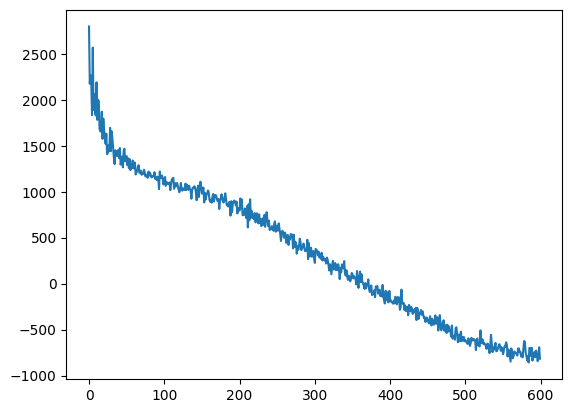

In [18]:
pyro.clear_param_store()

simple_linear_mixed = SimpleLinear(
        categorical={"x_cat": x_cat}, continuous={"x_con": x_con}, outcome=y_mixed
    )

guide_mixed = run_svi_inference(
    simple_linear_mixed,
    n_steps=n_steps,
    lr=0.01,
    verbose=True,
    **model_kwargs_mixed
)

predictive_mixed = Predictive(
    simple_linear_mixed, guide=guide_mixed, num_samples=1000,) # parallel=True) # fails for extraneous data

samples_mixed = predictive_mixed(**model_kwargs_mixed)

mixed_cat_0 = samples_mixed["weights_categorical_x_cat"][:, :, 0].squeeze()
mixed_cat_1 = samples_mixed["weights_categorical_x_cat"][:, :, 1].squeeze()

assert mixed_cat_1.mean() - mixed_cat_0.mean() > 1.2
assert samples_mixed["weight_continuous"].squeeze().mean() > 1.2

test_kwargs ={"categorical": {'x_cat': x_cat_test}, 
            "continuous" : {'x_con': x_con_test},
            "outcome" : None}


samples_test = predictive_mixed({'x_cat': x_cat_test}, continuous = {'x_con': x_con_test}, outcome = None)
outcome_preds = samples_test['outcome_observed'].squeeze().mean(axis=0)
print(outcome_preds)
target = torch.tensor([-2.,2.,2.,4.])
assert torch.allclose(outcome_preds, target, atol=0.4)

In [58]:
predictive_model = PredictiveModel(simple_linear_mixed, guide)


with pyro.poutine.trace() as tr:
    predictive_model({'x_cat': x_cat_test}, continuous = {'x_con': x_con_test}, outcome = None)

tr.trace.nodes['outcome_observed']['value'].shape
#predictive_model(x_cat, x_con, outcome=None)
# samples_test = predictive_mixed({'x_cat': x_cat_test}, continuous = {'x_con': x_con_test}, outcome = None)
# outcome_preds = samples_test['outcome_observed'].squeeze().mean(axis=0)
# print(outcome_preds)
# target = torch.tensor([-2.,2.,2.,4.])
# assert torch.allclose(outcome_preds, target, atol=0.4)

torch.Size([4])

In [106]:

class SimpleLinearRegisteredInput(pyro.nn.PyroModule):
    def __init__(self, model, categorical =  Dict[str, torch.tensor],
                 continuous = Dict[str, torch.tensor],
                 outcome = None):
        super().__init__()
        self.model = model
        
        def unconditioned_model():
            _categorical = {}
            _continuous = {}
            with pyro.plate("initiate", size=n, dim=-1):
                for key in categorical.keys():
                    _categorical[key] = pyro.sample(f"categorical_{key}",
                                                        dist.Bernoulli(.5))
                for key in continuous.keys():
                    _continuous[key] = pyro.sample(f"continuous_{key}",
                                                    dist.Normal(0,1))
            return  self.model(categorical = _categorical, 
                        continuous = _continuous,
                          outcome = None)
        
        self.unconditioned_model = unconditioned_model
        
        data = {**{
            f"categorical_{key}": categorical[key] for key 
            in categorical.keys()},
            **{
            f"continuous_{key}": continuous[key] for key
            in continuous.keys()
            }
            }
        
        self.data = data

        conditioned_model = condition(self.unconditioned_model, 
                                      data = self.data)   

        self.conditioned_model = conditioned_model


    def forward(self):
        return self.conditioned_model()
    
predictive_model = PredictiveModel(
    simple_linear_mixed, guide=guide_mixed)

predictive_model(categorical = {'x_cat': x_cat_test}, 
                 continuous = {'x_con': x_con_test}, 
                 outcome = None)

predictive_model_registered =  SimpleLinearRegisteredInput(
    predictive_model, categorical =  {'x_cat': x_cat_test}, 
            continuous =  {'x_con': x_con_test},)

with pyro.poutine.trace() as tr:
    before = predictive_model_registered()

target_before = torch.tensor([-2.,2.,2.,4.])

assert torch.allclose(before, target_before, atol=0.4)

with do(actions = {'categorical_x_cat': torch.tensor([1,1,1,1]),
                   "continuous_x_con": torch.tensor([1.,1.,1.,1.])}):
    with pyro.poutine.trace() as tr:
        after = predictive_model_registered()

target_after = torch.tensor([4.,4.,4.,4.])

assert torch.allclose(after, target_after, atol=0.4)

# with MultiWorldCounterfactual(first_available_dim=-10) as mwc:
#     with do(actions = {'categorical_x_cat': torch.tensor([1,1,1,1])}):
#         with pyro.poutine.trace() as tr:
#             predicive_model_registered()